## Steps for downloading data from Kaggle

1. Set up API key (create new API token -> download json file -> move to ~/.kaggle/kaggle.json)
2. Install Kaggle CLI, join competition on Kaggle
3. `kaggle competitions download -c stanford-rna-3d-folding -p ../data`
4. Unzip the data

## Data exploration

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Bio import AlignIO, SeqIO
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import matplotlib.patches as mpatches

In [2]:
# set plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# load data
data_path = "data/"
train_labels = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
train_sequences = pd.read_csv(os.path.join(data_path, "train_sequences.csv"))

# display basic information
print("Train labels shape:", train_labels.shape)
print("Train sequences shape:", train_sequences.shape)

# checking first rows
display(train_labels.head())
display(train_sequences.head())

Train labels shape: (137095, 6)
Train sequences shape: (844, 5)


,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...
3,1HLX_A,GGGAUAACUUCGGUUGUCCC,1995-09-15,P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID,>1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*AP*UP*AP*A...
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU,1995-12-07,THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...,">1HMH_1|Chains A, C, E|HAMMERHEAD RIBOZYME-RNA..."


,resid,x_1,y_1,z_1
count,137095.000000,130950.000000,130950.000000,130950.000000
mean,897.255633,80.447315,84.040727,98.611226
std,1014.321987,147.422319,114.928902,119.410665
min,1.000000,-821.085999,-449.414001,-333.403992
25%,61.000000,-1.115750,-4.890750,2.218500
50%,481.000000,62.651501,67.901501,72.938499
75%,1459.500000,178.809753,170.451996,184.531750
max,4298.000000,849.887024,889.507996,668.776978


Missing values in train_labels: 18435
Missing values in train_sequences: 5


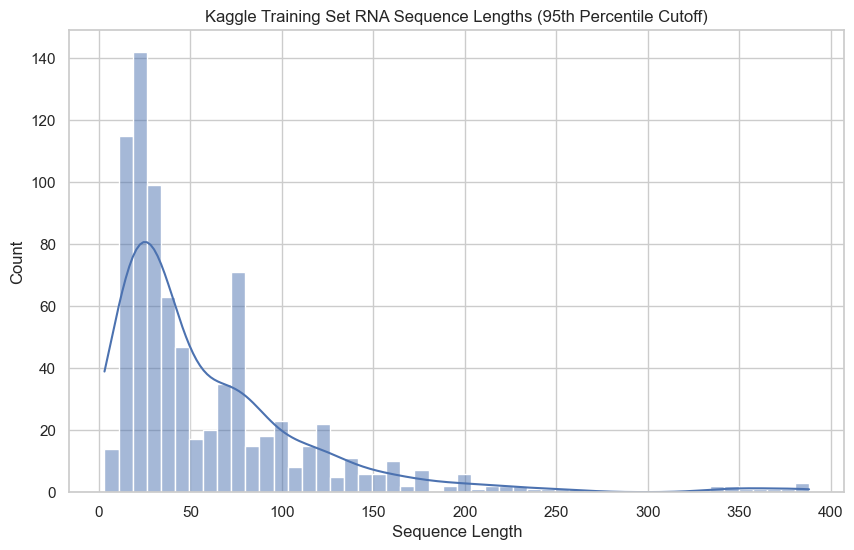

,A,C,G,U
count,844.000000,844.000000,844.000000,844.000000
mean,0.230887,0.253518,0.298922,0.216579
std,0.093352,0.072652,0.074965,0.095611
min,0.000000,0.000000,0.000000,0.000000
25%,0.181818,0.210526,0.259259,0.161400
50%,0.227273,0.252754,0.300000,0.213810
75%,0.272727,0.296547,0.344828,0.260870
max,1.000000,0.545455,0.545455,1.000000


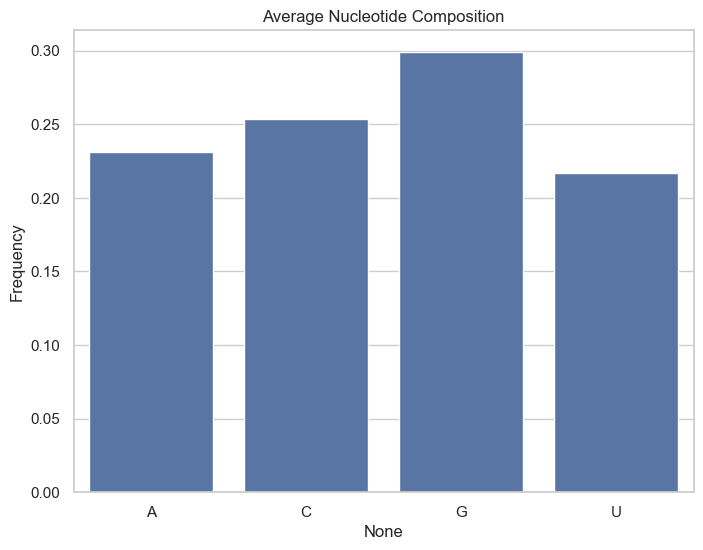

In [10]:
# basic stats
display(train_labels.describe())

# check missing vals
print("Missing values in train_labels:", train_labels.isnull().sum().sum())
print("Missing values in train_sequences:", train_sequences.isnull().sum().sum())

# distribution of sequence lengths
train_sequences['sequence_length'] = train_sequences['sequence'].apply(len)

# calculate 95th percentile for better visualization
length_95_percentile = np.percentile(train_sequences['sequence_length'], 95)
plt.figure(figsize=(10, 6))
sns.histplot(train_sequences[train_sequences['sequence_length'] <= length_95_percentile]['sequence_length'], 
             bins=50, kde=True)
plt.title('Kaggle Training Set RNA Sequence Lengths (95th Percentile Cutoff)')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

# nucleotide composition
def nucleotide_composition(seq):
    return {base: seq.count(base)/len(seq) for base in 'ACGU'}

# apply nucleotide composition to all sequences
nucleotide_comp = train_sequences['sequence'].apply(nucleotide_composition).apply(pd.Series)
nucleotide_stats = nucleotide_comp.describe()
display(nucleotide_stats)

# average nucleotide composition
plt.figure(figsize=(8, 6))
sns.barplot(x=nucleotide_stats.columns, y=nucleotide_stats.loc['mean'])
plt.title('Average Nucleotide Composition')
plt.ylabel('Frequency')
plt.show()

### MSA exploration

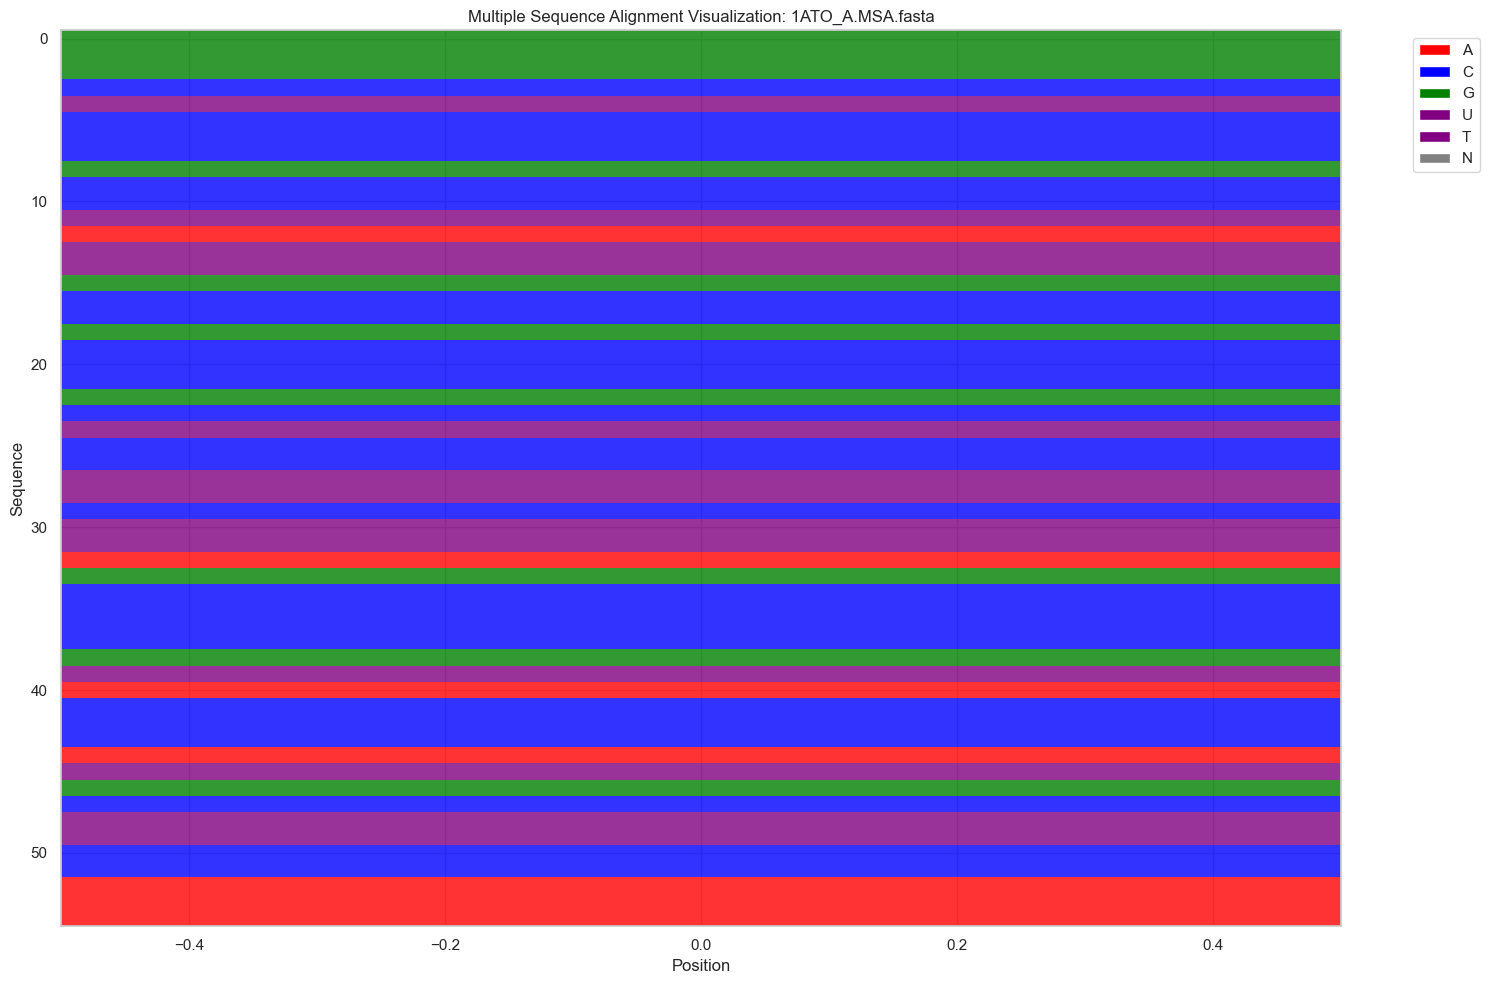

In [8]:
# visualizing MSA data :D!
msa_path = "MSA"

# assuming MSA files are in Stockholm format (.sto) or aligned FASTA (.afa)
def visualize_msa(msa_file, sample_size=100, figsize=(15, 10)):
    """Visualize a sample from Multiple Sequence Alignment"""
    try:
        alignment = AlignIO.read(msa_file, "stockholm")
    except:
        try:
            alignment = AlignIO.read(msa_file, "fasta")
        except:
            print(f"Could not read {msa_file} as Stockholm or FASTA format")
            return
    
    # sample sequences if there are too many
    if len(alignment) > sample_size:
        indices = np.random.choice(len(alignment), sample_size, replace=False)
        sampled_records = [alignment[i] for i in indices]
        alignment = alignment.__class__(sampled_records)
    
    # convert alignment to a character array for visualization
    align_array = np.array([list(rec) for rec in alignment])
    
    # map nucleotides to colors
    color_map = {'A': 'red', 'C': 'blue', 'G': 'green', 'U': 'purple', 'T': 'purple', 
                 '-': 'white', '.': 'white', 'N': 'gray'}
    
    # color array
    color_array = np.zeros(align_array.shape, dtype='U10')
    for i in range(align_array.shape[0]):
        for j in range(align_array.shape[1]):
            color_array[i, j] = color_map.get(align_array[i, j], 'black')
    
    # plot
    _, ax = plt.subplots(figsize=figsize)
    ax.imshow(np.arange(align_array.shape[0]).reshape(-1, 1), aspect='auto', alpha=0)
    
    # add colored cells
    for i in range(align_array.shape[0]):
        for j in range(align_array.shape[1]):
            if color_array[i, j] != 'white':
                ax.add_patch(mpatches.Rectangle((j-0.5, i-0.5), 1, 1, 
                                               facecolor=color_array[i, j], 
                                               edgecolor='none', alpha=0.8))
    
    # legend
    legend_elements = [mpatches.Patch(facecolor=color, label=nuc) 
                       for nuc, color in color_map.items() 
                       if color != 'white']
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f'Multiple Sequence Alignment Visualization: {os.path.basename(msa_file)}')
    plt.xlabel('Position')
    plt.ylabel('Sequence')
    plt.tight_layout()
    plt.show()

visualize_msa(os.path.join(data_path, f"{msa_path}/1ATO_A.MSA.fasta"))

# interactive MSA visualization with plotly
def interactive_msa_heatmap(msa_file, sample_size=100):
    """Create an interactive heatmap of MSA conservation"""
    try:
        alignment = AlignIO.read(msa_file, "stockholm")
    except:
        try:
            alignment = AlignIO.read(msa_file, "fasta")
        except:
            print(f"Could not read {msa_file} as Stockholm or FASTA format")
            return
    
    if len(alignment) > sample_size:
        indices = np.random.choice(len(alignment), sample_size, replace=False)
        sampled_records = [alignment[i] for i in indices]
        alignment = alignment.__class__(sampled_records)
    
    # calculate conservation at each position
    align_length = alignment.get_alignment_length()
    conservation = []
    
    for i in range(align_length):
        column = alignment[:, i]
        counts = Counter(column)
        # remove gaps
        if '-' in counts:
            del counts['-']
        if '.' in counts:
            del counts['.']
        
        # calculating conservation as frequency of most common nucleotide
        if counts:
            most_common = counts.most_common(1)[0][1]
            conservation.append(most_common / sum(counts.values()))
        else:
            conservation.append(0)
    
    # plot
    fig = px.line(x=list(range(align_length)), y=conservation,
                 labels={'x': 'Position', 'y': 'Conservation Score'},
                 title=f'Conservation Score Across MSA: {os.path.basename(msa_file)}')
    
    fig.update_layout(
        xaxis_title='Position in Alignment',
        yaxis_title='Conservation Score (0-1)',
        yaxis=dict(range=[0, 1])
    )
    
    fig.show()

interactive_msa_heatmap(os.path.join(data_path, f"{msa_path}/1ATO_A.MSA.fasta"))

## Visualizing RNA structure (labels)

In [11]:
import plotly.express as px

def visualize_structure_plotly(csv_path, idx):
    df = pd.read_csv(csv_path)
    structure_id = df['ID'].iloc[idx].split('_')[0]
    structure_mask = df['ID'].str.startswith(structure_id)
    padding_mask = (df['x_1'] != -1e18) & (df['y_1'] != -1e18) & (df['z_1'] != -1e18)
    df_filtered = df[structure_mask & padding_mask]
    fig = px.scatter_3d(df_filtered, 
                        x='x_1', y='y_1', z='z_1',
                        color='resname',
                        hover_data=['resid', 'resname'],
                        title=f'RNA Structure Visualization: {structure_id}')
    
    fig.update_traces(marker=dict(size=1))
    fig.show()

visualize_structure_plotly('data/validation_labels.csv', 1)

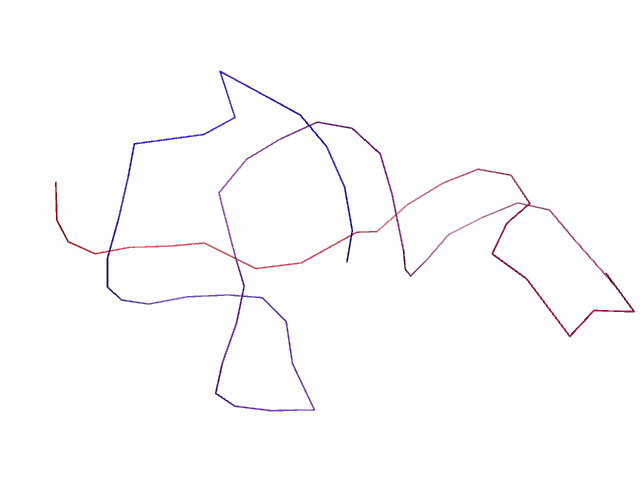

In [24]:
from pymol import cmd

def visualize_structure_pymol(csv_path, idx):
    df = pd.read_csv(csv_path)
    structure_id = df['ID'].iloc[idx].split('_')[0]
    structure_mask = df['ID'].str.startswith(structure_id)
    padding_mask = (df['x_1'] != -1e18) & (df['y_1'] != -1e18) & (df['z_1'] != -1e18)
    df_filtered = df[structure_mask & padding_mask].sort_values('resid')
    
    cmd.delete('all')
    
    # creating pseudoatoms & bonds
    prev_name = None
    for _, row in df_filtered.iterrows():
        pos = [float(row['x_1']), float(row['y_1']), float(row['z_1'])]
        current_name = f"{row['resname']}{row['resid']}"
        
        cmd.pseudoatom('rna',
                      pos=str(pos),
                      name=current_name,
                      resn=row['resname'],
                      resi=str(row['resid']))
        
        # create bond to previous residue
        if prev_name is not None:
            cmd.bond(f'rna and name {prev_name}', f'rna and name {current_name}')
        
        prev_name = current_name
    
    # style
    cmd.show('ribbon')
    cmd.hide('sticks')
    cmd.set('ribbon_width', 20)
    cmd.spectrum('count', 'blue_red', 'rna')
    cmd.set('sphere_scale', 20)
    cmd.orient()
    cmd.set('ray_shadows', 0)
    
    return cmd.ipython_image()

visualize_structure_pymol('data/validation_labels.csv', 1)

## Embedding exploration
- Evo2
- Others?

In [6]:
import requests
import io
import base64
import zipfile
import json
import os
from tqdm.auto import tqdm
import pickle
import umap
from collections import defaultdict
import constants

URL = os.getenv("URL", "https://health.api.nvidia.com/v1/biology/arc/evo2-40b/forward")
layer_name = 'blocks.28.mlp.l3'

def get_embedding(sequence):
    r = requests.post(
        url=URL,
        headers={"Authorization": f"Bearer {constants.NVIDIA_API}"},
        json={"sequence": sequence, "output_layers": [layer_name]},
    )
    content_type = r.headers.get("Content-Type", "")
    if "application/json" in content_type:
        response_json = r.json()
        b64_npz = response_json["data"]
    elif "application/zip" in content_type:
        zip_data = io.BytesIO(r.content)
        with zipfile.ZipFile(zip_data, "r") as zf:
            response_filename = zf.namelist()[0]
            with zf.open(response_filename) as f:
                response_text = f.read().decode("utf-8")
        response_json = json.loads(response_text)
        b64_npz = response_json["data"]
    npz_bytes = io.BytesIO(base64.b64decode(b64_npz))
    npz_file = np.load(npz_bytes)
    key = npz_file.files[0]
    embedding = npz_file[key]  # shape: (1, seq_len, 8192)
    print("Embedding shape:", embedding.shape)
    print("Sequence length:", len(sequence))
    return embedding.squeeze(0)  # shape: (16, 8192)

def get_embeddings_for_sequences(sequences, target_ids, batch_size=32):
    """Get Evo2 embeddings for RNA sequences using NVIDIA's API
    
    Args:
        sequences (list): List of RNA sequences
        target_ids (list): List of corresponding target IDs
        batch_size (int): Number of sequences to process at once
        
    Returns:
        dict: Mapping of target_id to embedding
    """
    embeddings_dict = {}
    full_embeddings_dict = {}
    
    # process sequences in batches
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i + batch_size]
        batch_ids = target_ids[i:i + batch_size]
        
        for seq, target_id in zip(batch_seqs, batch_ids):
            try:
                # get embedding for sequence
                embedding = get_embedding(seq)
                full_embeddings_dict[target_id] = embedding
                # average across sequence length to get fixed-size representation
                seq_embedding = np.mean(embedding, axis=0)  # shape: (8192,)
                embeddings_dict[target_id] = seq_embedding
            except Exception as e:
                print(f"Error processing sequence {target_id}: {str(e)}")
                continue
            
    return embeddings_dict, full_embeddings_dict

train_sequences = pd.read_csv("data/train_sequences.csv")

print("Getting embeddings for training sequences...")
embeddings_dict , full_embeddings_dict = get_embeddings_for_sequences(
    train_sequences['sequence'].tolist(),
    train_sequences['target_id'].tolist()
)

print("Saving embeddings...")
with open('data/nvidia_evo2_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)
with open('data/nvidia_evo2_full_embeddings.pkl', 'wb') as f:
    pickle.dump(full_embeddings_dict, f)

Getting embeddings for training sequences...


  0%|          | 0/27 [00:00<?, ?it/s]

Embedding shape: (1, 29, 8192)
Sequence length: 29
Embedding shape: (1, 34, 8192)
Sequence length: 34
Embedding shape: (1, 24, 8192)
Sequence length: 24
Embedding shape: (1, 20, 8192)
Sequence length: 20
Embedding shape: (1, 34, 8192)
Sequence length: 34
Embedding shape: (1, 12, 8192)
Sequence length: 12
Embedding shape: (1, 25, 8192)
Sequence length: 25
Embedding shape: (1, 32, 8192)
Sequence length: 32
Embedding shape: (1, 19, 8192)
Sequence length: 19
Embedding shape: (1, 28, 8192)
Sequence length: 28
Embedding shape: (1, 29, 8192)
Sequence length: 29
Embedding shape: (1, 12, 8192)
Sequence length: 12
Embedding shape: (1, 12, 8192)
Sequence length: 12
Embedding shape: (1, 34, 8192)
Sequence length: 34
Embedding shape: (1, 12, 8192)
Sequence length: 12
Embedding shape: (1, 32, 8192)
Sequence length: 32
Embedding shape: (1, 22, 8192)
Sequence length: 22
Embedding shape: (1, 19, 8192)
Sequence length: 19
Embedding shape: (1, 12, 8192)
Sequence length: 12
Embedding shape: (1, 29, 8192)


In [ ]:
import requests
import io
import base64
import zipfile
import json
import os
from tqdm.auto import tqdm
import pickle
import umap
from collections import defaultdict
import constants

URL = os.getenv("URL", "https://health.api.nvidia.com/v1/biology/arc/evo2-40b/forward")
layer_name = 'blocks.28.mlp.l3'

def get_embedding(sequence):
    r = requests.post(
        url=URL,
        headers={"Authorization": f"Bearer {constants.NVIDIA_API}"},
        json={"sequence": sequence, "output_layers": [layer_name]},
    )
    content_type = r.headers.get("Content-Type", "")
    if "application/json" in content_type:
        response_json = r.json()
        b64_npz = response_json["data"]
    elif "application/zip" in content_type:
        zip_data = io.BytesIO(r.content)
        with zipfile.ZipFile(zip_data, "r") as zf:
            response_filename = zf.namelist()[0]
            with zf.open(response_filename) as f:
                response_text = f.read().decode("utf-8")
        response_json = json.loads(response_text)
        b64_npz = response_json["data"]
    npz_bytes = io.BytesIO(base64.b64decode(b64_npz))
    npz_file = np.load(npz_bytes)
    key = npz_file.files[0]
    embedding = npz_file[key]  # shape: (1, seq_len, 8192)
    print("Embedding shape:", embedding.shape)
    print("Sequence length:", len(sequence))
    return embedding.squeeze(0)  # shape: (16, 8192)

def get_embeddings_for_sequences(sequences, target_ids, batch_size=32):
    """Get Evo2 embeddings for RNA sequences using NVIDIA's API
    
    Args:
        sequences (list): List of RNA sequences
        target_ids (list): List of corresponding target IDs
        batch_size (int): Number of sequences to process at once
        
    Returns:
        dict: Mapping of target_id to embedding
    """
    embeddings_dict = {}
    full_embeddings_dict = {}
    
    # process sequences in batches
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i + batch_size]
        batch_ids = target_ids[i:i + batch_size]
        
        for seq, target_id in zip(batch_seqs, batch_ids):
            try:
                # get embedding for sequence
                embedding = get_embedding(seq)
                full_embeddings_dict[target_id] = embedding
                # average across sequence length to get fixed-size representation
                seq_embedding = np.mean(embedding, axis=0)  # shape: (8192,)
                embeddings_dict[target_id] = seq_embedding
            except Exception as e:
                print(f"Error processing sequence {target_id}: {str(e)}")
                continue
            
    return embeddings_dict, full_embeddings_dict

train_sequences = pd.read_csv("data/train_sequences.csv")

print("Getting embeddings for training sequences...")
embeddings_dict , full_embeddings_dict = get_embeddings_for_sequences(
    train_sequences['sequence'].tolist(),
    train_sequences['target_id'].tolist()
)

print("Saving embeddings...")
with open('data/nvidia_evo2_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)
with open('data/nvidia_evo2_full_embeddings.pkl', 'wb') as f:
    pickle.dump(full_embeddings_dict, f)

In [30]:
print("Loading embeddings...")
with open('data/nvidia_evo2_embeddings.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

print("\nFirst 3 items in embeddings dict:")
for i, (target_id, embedding) in enumerate(list(embeddings_dict.items())[:3]):
    print(f"\nTarget ID: {target_id}")
    print(f"Embedding shape: {embedding.shape}")
    print(f"Embedding mean: {embedding.mean():.4f}")
    print(f"Embedding std: {embedding.std():.4f}")
    print(f"First 5 values: {embedding[:5]}")

print("\nOverall statistics:")
print(f"Number of sequences embedded: {len(embeddings_dict)}")
print(f"Embedding dimension: {next(iter(embeddings_dict.values())).shape}")

print("\nChecking for anomalies...")
embedding_lengths = [len(emb) for emb in embeddings_dict.values()]
if len(set(embedding_lengths)) > 1:
    print("WARNING: Not all embeddings have the same length!")
    print(f"Unique lengths found: {set(embedding_lengths)}")
else:
    print("All embeddings have consistent length ✓")

nan_count = sum(np.isnan(emb).any() for emb in embeddings_dict.values())
if nan_count > 0:
    print(f"WARNING: Found {nan_count} embeddings with NaN values!")
else:
    print("No NaN values found ✓")

Loading embeddings...

First 3 items in embeddings dict:

Target ID: 1SCL_A
Embedding shape: (8192,)
Embedding mean: 0.0000
Embedding std: 0.0000
First 5 values: [ 2.52401931e-12  1.91417763e-12  2.14069375e-12  2.81815950e-12
 -2.37557100e-13]

Target ID: 1RNK_A
Embedding shape: (8192,)
Embedding mean: 0.0000
Embedding std: 0.0000
First 5 values: [ 1.36430001e-12  1.03394540e-12  1.15760587e-12  1.52130269e-12
 -1.26508485e-13]

Target ID: 1RHT_A
Embedding shape: (8192,)
Embedding mean: 0.0000
Embedding std: 0.0000
First 5 values: [ 2.50993670e-12  1.90173803e-12  2.13024043e-12  2.80036179e-12
 -2.33067616e-13]

Overall statistics:
Number of sequences embedded: 844
Embedding dimension: (8192,)

Checking for anomalies...
All embeddings have consistent length ✓
No NaN values found ✓


In [ ]:
# get evo2 embedding for each of train sequences ✅

# test if evo2 UMAP can put similar-looking RNAs closer than dissimilar-looking RNAs

# potentially use evo2 to test if it can differentiate between RFDiffusion sequences and PDB real sequences? -- use UMAP?

In [9]:
rhofold_train_lengths = []
from Bio import SeqIO
import os

# Get all fasta files in the directory
fasta_files = [f for f in os.listdir('data/RNA3D_DATA/seq') if f.endswith('.seq')]

# Read each file and get sequence lengths
for file in fasta_files:
    file_path = os.path.join('data/RNA3D_DATA/seq', file)
    for record in SeqIO.parse(file_path, "fasta"):
        rhofold_train_lengths.append(len(record.seq))

print(f"Loaded {len(rhofold_train_lengths)} sequence lengths")
print(f"Min length: {min(rhofold_train_lengths) if rhofold_train_lengths else 'N/A'}")
print(f"Max length: {max(rhofold_train_lengths) if rhofold_train_lengths else 'N/A'}")
print(f"Mean length: {sum(rhofold_train_lengths)/len(rhofold_train_lengths) if rhofold_train_lengths else 'N/A':.2f}")

TypeError: parse() got an unexpected keyword argument 'encoding'

: 

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create logarithmically spaced bins for better distribution visualization
min_length = min(rhofold_train_lengths)
max_length = max(rhofold_train_lengths)
bins = np.logspace(np.log10(min_length), np.log10(max_length), 50)
plt.hist(rhofold_train_lengths, bins=bins, alpha=0.7, edgecolor='black')
plt.title('Distribution of RNA Sequence Lengths in RhoFold Training Data')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.xscale('log')  # Set x-axis to logarithmic scale
mean_length = sum(rhofold_train_lengths)/len(rhofold_train_lengths)
plt.axvline(x=mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'rhofold_train_lengths' is not defined